In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from datasets import *
from models import *
from transforms import *
from profiler import *

Available workers: 16


In [ ]:
d = WingbeatsDataset(dsname="Flytrap/pcfruit1", custom_label=[1], clean=False, transform=transforms.Compose([Bandpass(), NormalizedPSDSums(norm='l2')]))
dloader = DataLoader(d, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
sums = []
for s,_,_,_,_ in tqdm(dloader, total=len(d)//32):
    sums.extend(s)
sums = pd.DataFrame(torch.tensor(sums), columns=['sums'])
plt.ylim(0,900)
np_hist(sums, 'sums', res=0.1)

In [ ]:
suz = WingbeatsDataset(dsname="Flytrap/pcfruit1", custom_label=[1], clean=True, transform=transforms.Compose([Bandpass(), TransformWingbeat(setting='stft')]))

In [ ]:
plt.imshow(suz[13][0][0])
# .shape

  0%|          | 0/12 [00:00<?, ?it/s]

Found 394 in dataset: Flytrap_rpi/Backup_rpi_freeflight_20210328, and 1 label(s): ['Backup_rpi_freeflight_20210328']
Label(s) changed to [1]


13it [00:17,  1.38s/it]                       


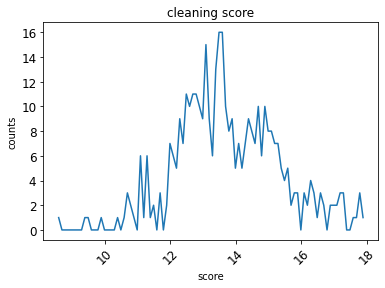

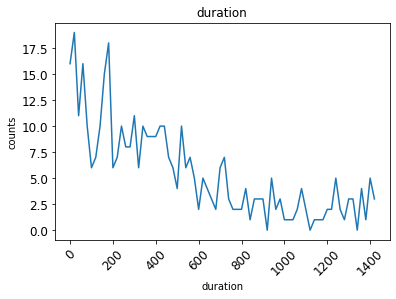

In [3]:
d = WingbeatsDataset(dsname="Flytrap_rpi/Backup_rpi_freeflight_20210328", custom_label=[1], clean=False, transform=transforms.Compose([Bandpass(highcut=2500.), NormalizedPSDSums(norm='l2')]))
dloader = DataLoader(d, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
sums,paths, idx = [],[], []
for s,_,p,i,_ in tqdm(dloader, total=len(d)//32):
    sums.extend(s)
    paths.extend(p)
    idx.extend(i)
df = pd.DataFrame({"path": paths, "score": torch.tensor(sums)})
df['duration'] = df.path.apply(lambda x: get_wbt_duration(x, window=150, th=0.003))
df['sum'] = df.path.apply(lambda x: open_wingbeat(x).abs().sum())
df['idx'] = idx
plt.figure()
plt.title('cleaning score')
np_hist(df, 'score')
plt.figure()
plt.title('duration')
np_hist(df,'duration', res=20)

100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


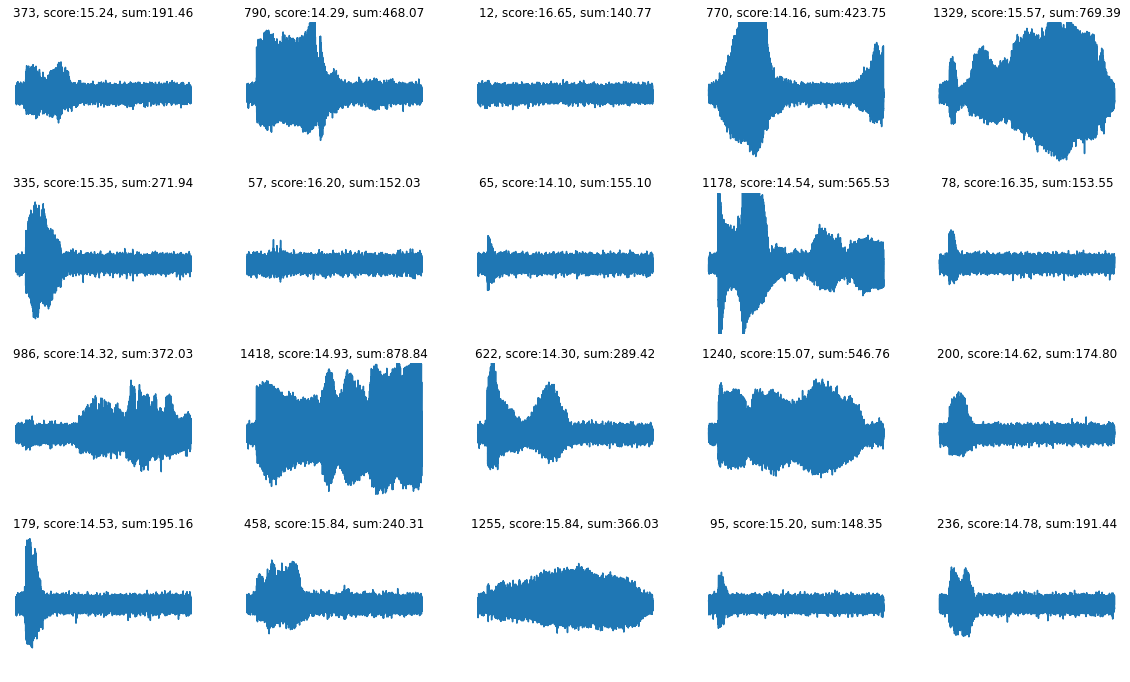

In [4]:
selection = "score > 14 & score < 17 & duration>30"# & sum > 184"

tmp = df.query(selection).sample(20) 
plt.figure(figsize=(20,12))

for i in tqdm(range(len(tmp))):
    plt.subplot(4,5,i+1)
    sig = open_wingbeat(tmp.iloc[i].path, )
    dur = get_wbt_duration(tmp.iloc[i].path, window=150, th=0.003)
    plt.plot(sig.T);
    plt.title(f"{dur:.0f}, score:{tmp.score.iloc[i]:.2f}, sum:{sig.abs().sum():.2f}");
    plt.axis('off')
    plt.ylim(-.05,.05)

In [5]:
tmp1 = tmp

  0%|          | 0/9 [00:00<?, ?it/s]

Found 318 in dataset: Flytrap_rpi/backup of flytrap rbpi data - pcfruit tests, and 1 label(s): ['backup of flytrap rbpi data - pcfruit tests']
Label(s) changed to [1]


10it [00:14,  1.45s/it]                      


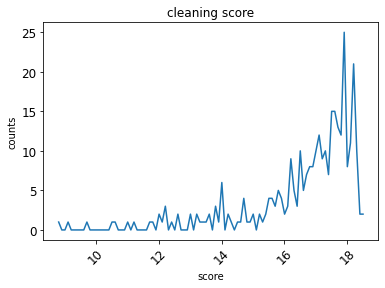

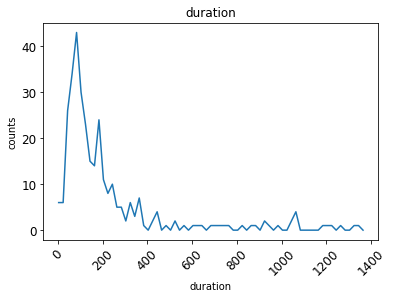

In [6]:
d = WingbeatsDataset(dsname="Flytrap_rpi/backup of flytrap rbpi data - pcfruit tests", custom_label=[1], clean=False, transform=transforms.Compose([Bandpass(highcut=2500.), NormalizedPSDSums(norm='l2')]))
dloader = DataLoader(d, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
sums,paths, idx = [],[], []
for s,_,p,i,_ in tqdm(dloader, total=len(d)//32):
    sums.extend(s)
    paths.extend(p)
    idx.extend(i)
df = pd.DataFrame({"path": paths, "score": torch.tensor(sums)})
df['duration'] = df.path.apply(lambda x: get_wbt_duration(x, window=150, th=0.003))
df['sum'] = df.path.apply(lambda x: open_wingbeat(x).abs().sum())
df['idx'] = idx
plt.figure()
plt.title('cleaning score')
np_hist(df, 'score')
plt.figure()
plt.title('duration')
np_hist(df,'duration', res=20)

100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


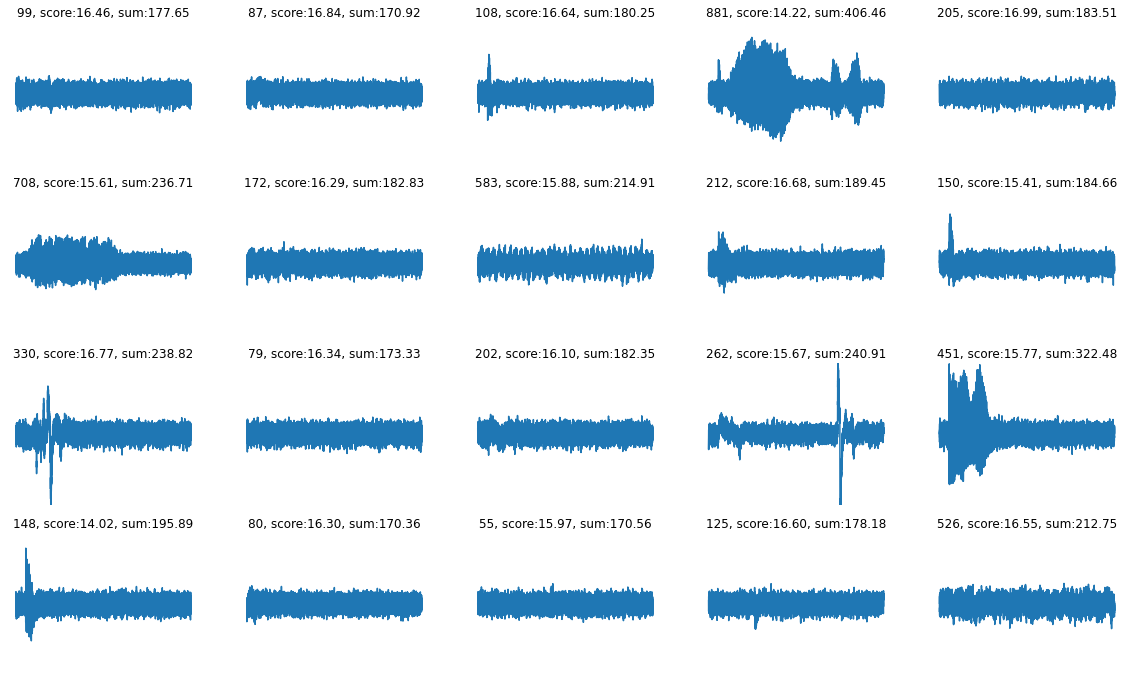

In [7]:
selection = "score > 14 & score < 17 & duration>10"# & sum > 184"

tmp = df.query(selection).sample(20) 
plt.figure(figsize=(20,12))

for i in tqdm(range(len(tmp))):
    plt.subplot(4,5,i+1)
    sig = open_wingbeat(tmp.iloc[i].path, )
    dur = get_wbt_duration(tmp.iloc[i].path, window=150, th=0.003)
    plt.plot(sig.T);
    plt.title(f"{dur:.0f}, score:{tmp.score.iloc[i]:.2f}, sum:{sig.abs().sum():.2f}");
    plt.axis('off')
    plt.ylim(-.05,.05)

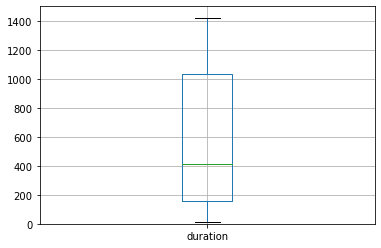

In [18]:
tmp1.drop('score',axis=1).boxplot(showfliers=False);
plt.ylim(0,1500);

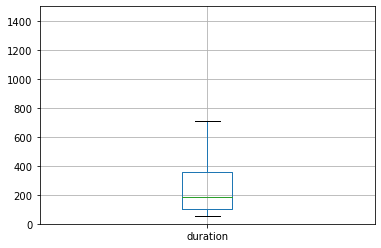

In [19]:
tmp.drop('score',axis=1).boxplot(showfliers=False);
plt.ylim(0,1500);

In [149]:
%matplotlib qt
sig = open_wingbeat(tmp.iloc[17].path)
plt.plot(sig.T)
plt.show()

In [153]:
dstft = WingbeatsDataset(dsname="Flytrap_rpi/backup of flytrap rbpi data - pcfruit tests", custom_label=[1], clean=False, transform=transforms.Compose([Bandpass(highcut=2500.), TransformWingbeat(setting='stft')]))

plt.imshow(dstft[tmp.iloc[17].name][0][0])
plt.show()

Found 318 in dataset: Flytrap_rpi/backup of flytrap rbpi data - pcfruit tests, and 1 label(s): ['backup of flytrap rbpi data - pcfruit tests']
Label(s) changed to [1]


  5%|▌         | 1/20 [00:00<00:02,  7.01it/s]

Found 318 in dataset: Flytrap_rpi/backup of flytrap rbpi data - pcfruit tests, and 1 label(s): ['backup of flytrap rbpi data - pcfruit tests']
Label(s) changed to [1]


100%|██████████| 20/20 [00:01<00:00, 10.63it/s]


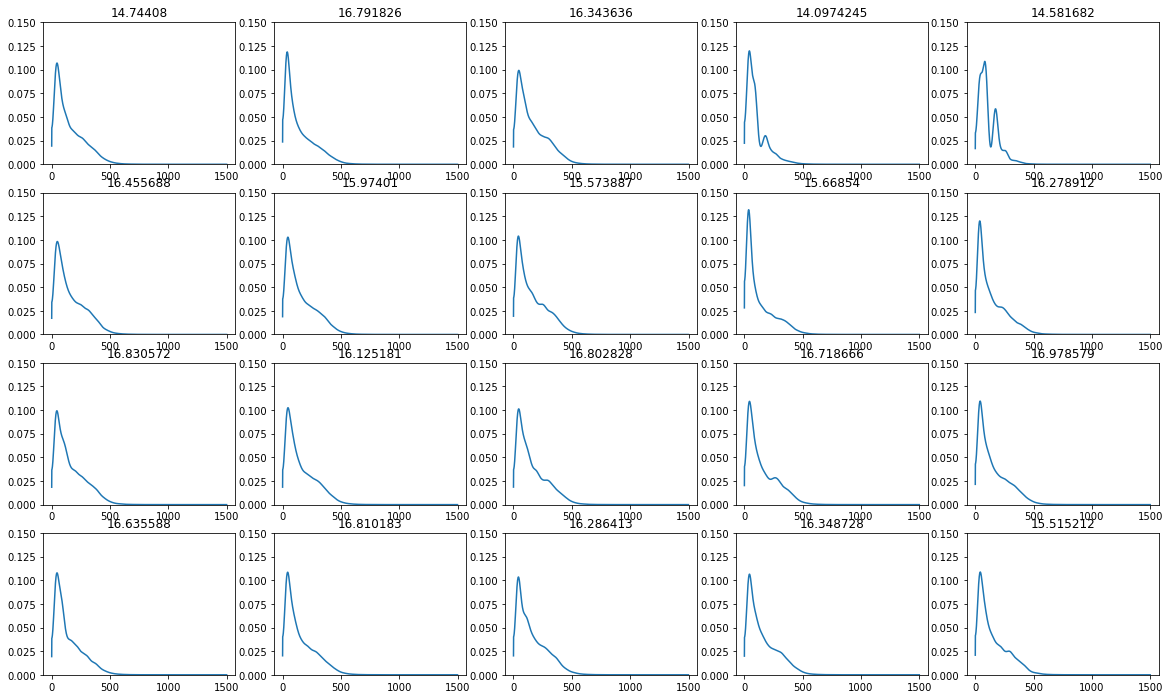

In [212]:
dpsd = WingbeatsDataset(dsname="Flytrap_rpi/backup of flytrap rbpi data - pcfruit tests", custom_label=[1], clean=False, transform=transforms.Compose([Bandpass(highcut=2500.), TransformWingbeat(setting='psdl2')]))
plt.figure(figsize=(20,12))
for i in tqdm(range(len(tmp))):
    plt.subplot(4,5,i+1)
    sig = dpsd[tmp.iloc[i].name][0].squeeze()[:1500]
    plt.plot(sig.T);
    plt.title(tmp.loc[tmp.iloc[i].name].score)
#     plt.axis('off')
    plt.ylim(0,.15)

In [199]:
dpsd[tmp.iloc[i].name][0].squeeze()[:500].shape

(500,)

In [151]:
d = WingbeatsDataset(dsname="Suzukii_RL/R", custom_label=[1], clean=False, transform=transforms.Compose([Bandpass(), NormalizedPSDSums(norm='l2')]))
dloader = DataLoader(d, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
sums = []
for s,_,_,_ in tqdm(dloader, total=len(d)//32):
    sums.extend(s)
sums = pd.DataFrame(torch.tensor(sums), columns=['sums'])
plt.ylim(0,900)
np_hist(sums, 'sums', res=0.1)

  0%|          | 0/448 [00:00<?, ?it/s]

Found 14348 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


  0%|          | 0/448 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 4)

In [ ]:
d = WingbeatsDataset(dsname="Flytrap/pcfruit1", custom_label=[1], clean=True)

In [ ]:
plt.hist(np.load('../data_created/Flytrap-pcfruit1_thL8.9_thH20_cleaned_sums.npy'), bins=150);

In [ ]:
n=1

plt.plot(d[n][0].T)
plt.title(len(torch.where(d[n][0] != 0)[1])/8000);

In [ ]:
d = WingbeatsDataset(dsname="Flytrap/pcfruit1", custom_label=[1], clean=True, transform=Focus())
rdm = np.random.randint(0,len(d))
# plt.plot(d[rdm][0].T)
# plt.title(len(torch.where(d[rdm][0] != 0)[1]))
durations = [len(torch.where(d[i][0] != 0)[1])/8000 for i in range(len(d))]
pd.DataFrame(durations).boxplot(showfliers=False);plt.ylim(0.2,0.9); plt.title(f"median:{pd.DataFrame(durations).iloc[:,0].median():.2f}s");

In [ ]:
d = WingbeatsDataset(dsname="Suzukii_RL/Y", custom_label=[1], clean=True, transform=Focus())
rdm = np.random.randint(0,len(d))
# plt.plot(d[rdm][0].T)
# plt.title(len(torch.where(d[rdm][0] != 0)[1]))
durations = [len(torch.where(d[i][0] != 0)[1])/8000 for i in range(len(d))]
pd.DataFrame(durations).boxplot(showfliers=False);plt.ylim(0.2,0.9); plt.title(f"median:{pd.DataFrame(durations).iloc[:,0].median():.2f}s");

In [ ]:
d = WingbeatsDataset(dsname="Suzukii_RL/X", custom_label=[1], clean=True, transform=Focus())
rdm = np.random.randint(0,len(d))
# plt.plot(d[rdm][0].T)
# plt.title(len(torch.where(d[rdm][0] != 0)[1]))
durations = [len(torch.where(d[i][0] != 0)[1])/8000 for i in range(len(d))]
pd.DataFrame(durations).boxplot(showfliers=False);plt.ylim(0.2,0.9); plt.title(f"median:{pd.DataFrame(durations).iloc[:,0].median():.2f}s");

In [ ]:
d = WingbeatsDataset(dsname="Suzukii_RL/L", custom_label=[1], clean=True, transform=Focus())
rdm = np.random.randint(0,len(d))
# plt.plot(d[rdm][0].T)
# plt.title(len(torch.where(d[rdm][0] != 0)[1]))
durations = [len(torch.where(d[i][0] != 0)[1])/8000 for i in range(len(d))]
pd.DataFrame(durations).boxplot(showfliers=False);plt.ylim(0.2,0.9); plt.title(f"median:{pd.DataFrame(durations).iloc[:,0].median():.2f}s");

In [ ]:
d = WingbeatsDataset(dsname="Suzukii_RL/R", custom_label=[1], clean=True, transform=Focus())
rdm = np.random.randint(0,len(d))
# plt.plot(d[rdm][0].T)
# plt.title(len(torch.where(d[rdm][0] != 0)[1]))
durations = [len(torch.where(d[i][0] != 0)[1])/8000 for i in range(len(d))]
pd.DataFrame(durations).boxplot(showfliers=False);plt.ylim(0.2,0.9); plt.title(f"median:{pd.DataFrame(durations).iloc[:,0].median():.2f}s");

In [ ]:
d = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[1], clean=True, transform=Focus())
rdm = np.random.randint(0,len(d))
# plt.plot(d[rdm][0].T)
# plt.title(len(torch.where(d[rdm][0] != 0)[1]))
durations = [len(torch.where(d[i][0] != 0)[1])/8000 for i in range(len(d))]
pd.DataFrame(durations).boxplot(showfliers=False);plt.ylim(0.2,0.9); plt.title(f"median:{pd.DataFrame(durations).iloc[:,0].median():.2f}s");

In [ ]:
d = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[1], clean=True, transform=Focus())
rdm = np.random.randint(0,len(d))
# plt.plot(d[rdm][0].T)
# plt.title(len(torch.where(d[rdm][0] != 0)[1]))
durations = [len(torch.where(d[i][0] != 0)[1])/8000 for i in range(len(d))]
pd.DataFrame(durations).boxplot(showfliers=False);plt.ylim(0.2,0.9); plt.title(f"median:{pd.DataFrame(durations).iloc[:,0].median():.2f}s");